# Generation of statistics for heatwave indices, by station, showing a map

Author: Hugo Carrillo

Creation: July 2024

Steps:
1. We show the selected stations in a map.
2. We read the indices HWN, HWF, HWD, HWM, HWA for each year and stations, produced by the previous notebook.
3. We produce figures for the trends of each heatwave index for each station in a map.
4. We produce a latex code that shows a table with the slopes, r2, and p-values for each station and index.

In [1]:
import sys
import os

import pandas as pd
import pickle


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # Suppress specific RuntimeWarnings

In [2]:
try:
    import geopandas as geo
except:
    %pip install geopandas=="0.13.2"
    import geopandas as geo

from shapely.geometry import box

from shapely.affinity import translate

In [3]:
%load_ext autoreload
%autoreload 2

# Parameters


In [42]:
METADATA_PATH_AND_FILENAME = 'data/original/cimis_metadata.csv'
CLEANED_DATA_PATH = 'data/cleaned/'
GEO_DATA_PATH = 'geo_data/'
MY_FUNCTIONS_PATH = '../functions/'
AUX_DATA_FOLDER = 'data/aux/'
PLOTS_FOLDER = 'plots/'
SHAPEFILE_NAME = 'ca_counties.zip'


# Rectangle for California
min_lon, min_lat, max_lon, max_lat = -125.0, 32.5, -113.8, 42

In [43]:
# Add the folder to the Python path
folder_path = os.path.abspath(MY_FUNCTIONS_PATH)
sys.path.insert(0, folder_path)

from HWFunctionsWithMaps import (
    KoeppenMapWithStations,
    plot_trends_years_all_indices
)

# Table 1: Information of the selected stations

In [44]:
stations = pd.read_csv(METADATA_PATH_AND_FILENAME)
statlist= [91, 90, 43, 6, 47, 70, 35, 39, 5, 52, 62] #sorted from N to S


stations = stations[stations['StationNbr'].isin(statlist)]
stations['latitude'] = stations['HmsLatitude'].apply(lambda x: x.split('/')[-1].strip())
stations['longitude'] = stations['HmsLongitude'].apply(lambda x: x.split('/')[-1].strip())

stations = stations.sort_values(by='latitude', ascending=False) #it sorts the stations metadata from N to S

# Generate the code for a table in LaTeX
# This table show information of the stations
latex_code = stations[['Name', 'latitude', 'longitude', 'Elevation']].to_latex(index=False).replace("\\\\", "\\")
print(latex_code)

\begin{tabular}{lllr}
\toprule
Name & latitude & longitude & Elevation \
\midrule
Tulelake FS & 41.958869 & -121.472370 & 4035 \
Alturas & 41.438214 & -120.480310 & 4405 \
McArthur & 41.063767 & -121.456020 & 3310 \
Davis & 38.535694 & -121.776360 & 60 \
Brentwood & 37.928258 & -121.6599 & 45 \
Manteca & 37.834822 & -121.223190 & 33 \
Bishop & 37.358514 & -118.405530 & 4170 \
Parlier & 36.597444 & -119.504040 & 337 \
Shafter & 35.532556 & -119.281790 & 360 \
San Luis Obispo & 35.305442 & -120.661780 & 330 \
Temecula & 33.486650 & -117.228270 & 1420 \
\bottomrule
\end{tabular}



# Reading geographical data

In [45]:
# shapefile
cal_map = geo.read_file(GEO_DATA_PATH + SHAPEFILE_NAME)

if cal_map.crs != 'EPSG:4326':
    cal_map = cal_map.to_crs('EPSG:4326')

# Clip the GeoDataFrame to the bounding box
bbox = box(min_lon, min_lat, max_lon, max_lat)
clipped_gdf = cal_map.clip(bbox)


# Koppen map
gdf_KM = geo.read_file(GEO_DATA_PATH + 'KG_1986-2010.zip')
bbox_KM = box(min_lon, min_lat, max_lon, max_lat)

# Clip the GeoDataFrame to the bounding box
gdf_KM = gdf_KM.clip(bbox)

# Plot 1: Köppen map with stattions

Color map: {5.0: '#CC8D14', 6.0: '#CCAA54', 7.0: '#FFCC00', 8.0: '#FFFF64', 10.0: '#005000', 12.0: '#96FF00', 13.0: '#00D700', 14.0: '#00AA00', 19.0: '#820082', 20.0: '#C800C8', 23.0: '#8C8C8C', 24.0: '#BEBEBE', 31.0: '#64FFFF', 32.0: '#F5FFFF'}


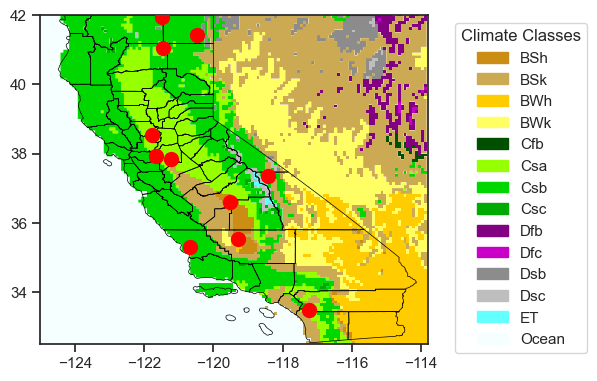

In [46]:
KoeppenMapWithStations(stations, clipped_gdf, gdf_KM, min_lon, min_lat, max_lon, max_lat,
                path = PLOTS_FOLDER, filename = 'KoeppenWithStationsCentralCalifornia.pdf')

# Reading the heatwave indices summary

In [47]:
filename = 'hw_Cal_summary.pkl'
with open(AUX_DATA_FOLDER + filename, 'rb') as f:
    hw_Cal_summary = pickle.load(f)

# Plot 2: Trends in each station

HWN
HWF
HWD
HWM
HWA


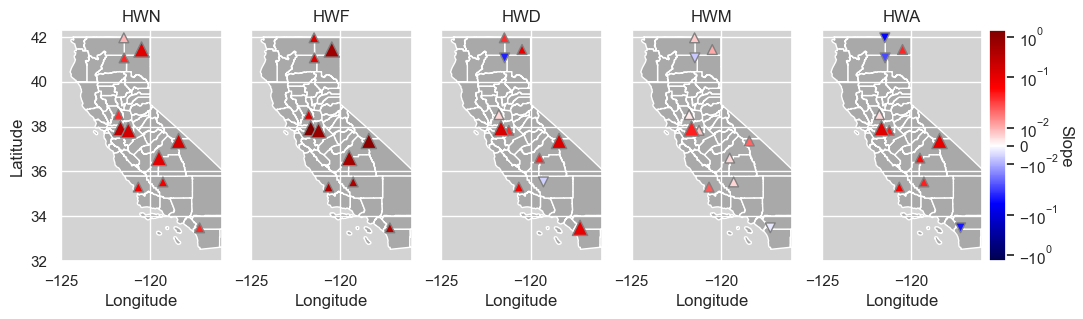

In [48]:
start = 1989
end = 2023

min_lon, min_lat, max_lon, max_lat = -125.0, 32.5-0.5, -116, 42.3#5 #-75.0, -42.0, -69.5, -29.0
fsize = [12.5, 3]
pos_adj = 1.2 # It helps to adjust the distance between subplots. Values around 1 seem to be ok.

trends, r_values, p_values = plot_trends_years_all_indices(start,end,hw_Cal_summary['MeteoChile']['CDA'],stations, cal_map, min_lon, min_lat, max_lon, max_lat,
                                  'MeteoChile', vmin=-1.45,vmax=1.45, fig_PATH=PLOTS_FOLDER, fsize = fsize,
                                  wspace=0.1, format = 'png', pos_adj=pos_adj)

# Table 2: Summary of trends

In [49]:
trends_stats={}

indices = ['HWN', 'HWF', 'HWD', 'HWM', 'HWA']
trends_df = pd.DataFrame(index=list(r_values['HWN'].keys()), columns = indices)
for hwi in list(r_values.keys()):
    #trends_df[hwi] = pd.DataFrame(columns = ['slope', 'r2', 'p_values'])
    trends_stats[hwi] = pd.DataFrame(index = list(r_values[hwi].keys()), columns = ['slope', 'r2', 'p_values'])
    trends_stats[hwi]['slope'] = pd.DataFrame.from_dict(trends[hwi], orient='index')[0]
    trends_stats[hwi]['r2'] = pd.DataFrame.from_dict(r_values[hwi], orient='index')[0]**2
    trends_stats[hwi]['p_values'] = pd.DataFrame.from_dict(p_values[hwi], orient='index')[0]

    trends_stats[hwi] = trends_stats[hwi].add_prefix(hwi + '_')

trends_df = pd.concat([trends_stats[hwi] for hwi in indices], axis=1)

def scientific_notation(x):
    # Format the number in scientific notation
    formatted = f'{x:.1e}'
    # Split the formatted string into coefficient and exponent parts
    coeff, exp = formatted.split('e')
    # Format the exponent to remove leading zeros
    exp = int(exp)
    # Return the formatted string as 1.2e-4
    return f'{coeff}e{exp}'


trends_df = trends_df.applymap(scientific_notation)

trends_df.index = stations['Name']

print(trends_df.to_latex(index=True))

\begin{tabular}{llllllllllllllll}
\toprule
 & HWN_slope & HWN_r2 & HWN_p_values & HWF_slope & HWF_r2 & HWF_p_values & HWD_slope & HWD_r2 & HWD_p_values & HWM_slope & HWM_r2 & HWM_p_values & HWA_slope & HWA_r2 & HWA_p_values \\
Name &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Tulelake FS & 9.5e-3 & 1.1e-3 & 8.5e-1 & 1.4e-1 & 8.5e-3 & 6.0e-1 & 2.9e-2 & 1.0e-2 & 5.7e-1 & 6.8e-3 & 1.3e-2 & 5.1e-1 & -5.0e-2 & 2.4e-2 & 3.8e-1 \\
Alturas & 1.2e-1 & 1.3e-1 & 3.0e-2 & 6.6e-1 & 1.6e-1 & 1.6e-2 & 9.4e-2 & 7.0e-2 & 1.2e-1 & 1.1e-2 & 2.2e-2 & 3.9e-1 & 3.3e-2 & 3.1e-2 & 3.1e-1 \\
McArthur & 3.3e-2 & 1.6e-2 & 4.7e-1 & 1.3e-1 & 9.2e-3 & 5.8e-1 & -3.3e-2 & 7.1e-3 & 6.3e-1 & -6.8e-3 & 1.1e-2 & 5.4e-1 & -2.3e-2 & 1.9e-2 & 4.3e-1 \\
Davis & 3.0e-2 & 1.2e-2 & 5.3e-1 & 1.4e-1 & 1.1e-2 & 5.5e-1 & 5.3e-3 & 3.3e-4 & 9.2e-1 & 2.6e-3 & 2.8e-3 & 7.6e-1 & 4.9e-3 & 1.4e-3 & 8.3e-1 \\
Brentwood & 2.8e-1 & 4.3e-1 & 1.7e-5 & 1.4e0 & 4.0e-1 & 4.8e-5 & 1.5e-1 & 1.8e-1 & 1.1e-2 & 3.6e-2 & 2.7e-1 & 1.4e-3 & 1

/var/folders/x9/shm48h2x00d0km04wyrz64mr0000gn/T/ipykernel_3690/1813065698.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trends_df = trends_df.applymap(latex_scientific_notation)
